In [67]:
import os
os.chdir(os.getcwd())

In [68]:
#limit VRAM usage
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [69]:
#check and remove dodgy images from dataset
import cv2
import imghdr

data_dir = 'data'
image_exts = ['jpg', 'jpeg', 'bmp', 'png']
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image extension not supported: ', format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: ', format(image_path))

In [70]:
#creating a dataset using keras and all the images in the data folder
import numpy as np
from matplotlib import pyplot as plt
#building a data pipeline
data = tf.keras.utils.image_dataset_from_directory('data')
validation = tf.keras.utils.image_dataset_from_directory('validation')
#scaling the data to be between 0 and 1 from 0 to 255
# logic - scaled = batch[0] / 255 but we apply this directly to the pipeline
data = data.map(lambda x, y: (x / 255, y)) # type: ignore
validation = validation.map(lambda x, y: (x / 255, y)) # type: ignore

Found 47009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.


In [71]:
#making it an interator to allow us to loop through the data
data_iterator = data.as_numpy_iterator() # type: ignore
validation_iterator = validation.as_numpy_iterator() # type: ignore
#grab a batch of data
batch = data_iterator.next()
batch1 = validation_iterator.next()
#batch[0].shape #shape of the images
print(batch[1]) 
print(batch1[1])
# Classification labels: 0 - Female, 1 - Male.

2023-07-26 17:26:48.686151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-26 17:26:48.686391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [47009]
	 [[{{node Placeholder/_0}}]]
2023-07-26 17:26:48.698029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1164

[0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 1 1 1]
[1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 1 1 0 1 1]


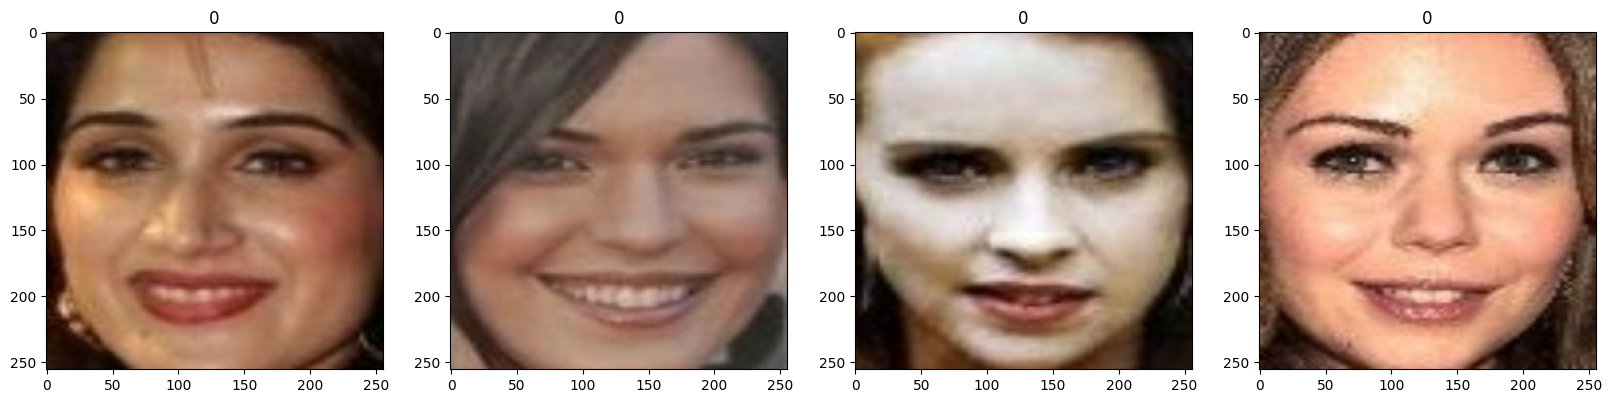

In [72]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    #ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])
    #ax[idx].title.set_text(batch[1][idx])

In [73]:
print('Data batches: ',len(data)) #number of batches of data
print('Validation data batches: ',len(validation)) #number of batches of validation data

Data batches:  1470
Validation data batches:  365


In [101]:
#making training, validation and test sets, they all add up to len(data) = 1470 in this case
train_size = len(data)
val_size = int(0.8 * len(validation))
test_size = int(0.2 * len(validation))
print(val_size)
train = data.take(train_size) # type: ignore
val = validation.take(val_size) # type: ignore
test = validation.skip(val_size).take(test_size) # type: ignore

292


In [75]:
#building the model
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [76]:
#training the model
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/40


2023-07-26 17:26:50.603092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]
2023-07-26 17:26:50.603349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [47009]
	 [[{{node Placeholder/_4}}]]


1470/1470 [==============================] - ETA: 0s - loss: 0.2628 - accuracy: 0.8920

2023-07-26 17:27:14.158611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [11649]
	 [[{{node Placeholder/_0}}]]
2023-07-26 17:27:14.158949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]


1470/1470 [==============================] - 45s 30ms/step - loss: 0.2628 - accuracy: 0.8920 - val_loss: 0.2753 - val_accuracy: 0.8790
Epoch 2/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.1732 - accuracy: 0.9345 - val_loss: 0.1569 - val_accuracy: 0.9392
Epoch 3/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.1299 - accuracy: 0.9514 - val_loss: 0.1337 - val_accuracy: 0.9491
Epoch 4/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.1035 - accuracy: 0.9626 - val_loss: 0.1334 - val_accuracy: 0.9536
Epoch 5/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.0781 - accuracy: 0.9725 - val_loss: 0.1557 - val_accuracy: 0.9518
Epoch 6/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.0518 - accuracy: 0.9815 - val_loss: 0.1870 - val_accuracy: 0.9484
Epoch 7/40
1470/1470 [==============================] - 25s 17ms/step - loss: 0.0408 - accuracy: 0.9854 - val_loss: 0.2515 - val_accura

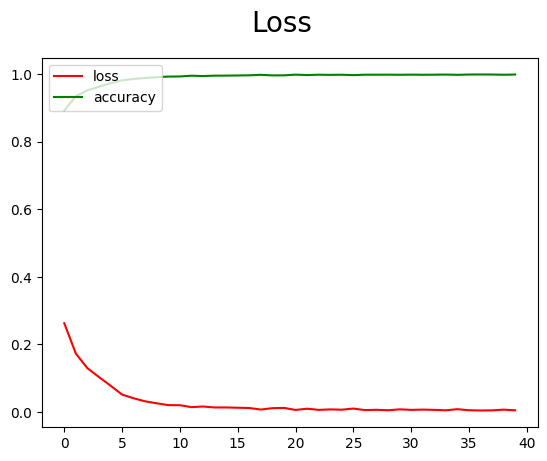

In [77]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='red', label='loss')
plt.plot(hist.history['accuracy'], color='green', label='accuracy')
#plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

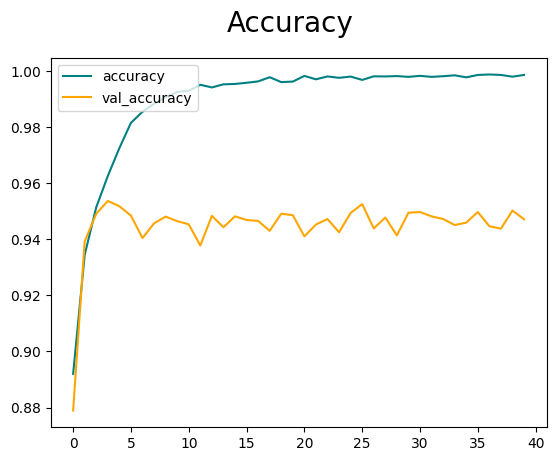

In [78]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [102]:
#Evaluate the model performance
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy # type: ignore
pre = Precision()
re = Recall()
acc = BinaryAccuracy()
len(test)

73

In [103]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-07-26 18:02:09.446311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]
2023-07-26 18:02:09.446571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [11649]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 11ms/step


In [104]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.9555741548538208, Recall: 0.9492089748382568, Accuracy: 0.9505422711372375


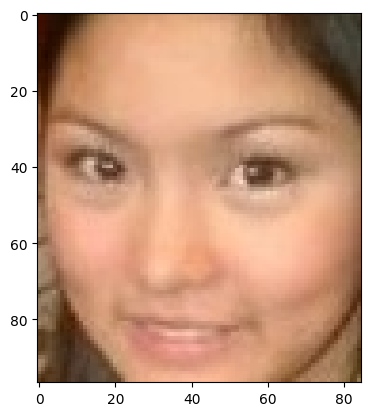

In [105]:
#Test the model
img = cv2.imread('ftest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

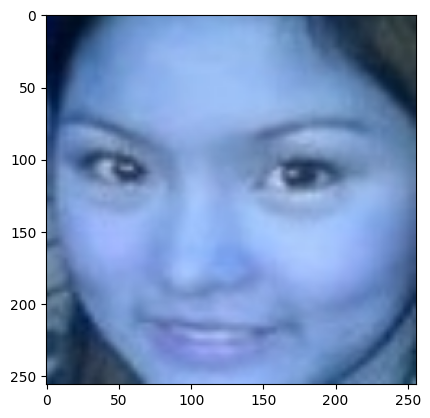

In [106]:
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int)) # type: ignore
plt.show()

In [107]:
np.expand_dims(resize, 0).shape
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat)
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 14ms/step
[[0.0026183]]
prediction: Female


In [108]:
#Save the model for future use.
from tensorflow.keras.models import load_model
model.save(os.path.join('models','gender_classifier.h5'))

In [109]:
#Load the saved model
new_model = load_model(os.path.join('models','gender_classifier.h5'))
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))
if yhat>0.5:
    print('prediction: Male')
else:
    print('prediction: Female')

1/1 [==============================] - 0s 45ms/step
prediction: Female
